# Relax Data Take Home Assessment

## Random Forest Classifier for Predicting future user adoption:

#### Premise:

The data is available as two attached CSV files:

takehome_user_engagement. csv

takehome_users . csv

The data has the following two tables:

1. A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
- *name*: the user's name
- *object_id*: the user's id
- *email*: email address
- *creation_source*: how their account was created. This takes on one of 5 values:
    - *PERSONAL_PROJECTS*: invited to join another user's personal workspace
    - *GUEST_INVITE*: invited to an organization as a guest (limited permissions)
    - *ORG_INVITE*: invited to an organization (as a full member)
    - *SIGNUP*: signed up via the website
    - *SIGNUP_GOOGLE_AUTH*: signed up using Google Authentication (using a Google email account for their login id)
- *creation_time*: when they created their account
- *last_session_creation_time*: unix timestamp of last login
- *opted_in_to_mailing_list*: whether they have opted into receiving marketing emails
- *enabled_for_marketing_drip*: whether they are on the regular marketing email drip
- *org_id*: the organization (group of users) they belong to
- *invited_by_user_id*: which user invited them to join (if applicable).

2. A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product. 

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period, identify which factors predict future user adoption.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [46]:
th_users = pd.read_csv('takehome_users.csv', encoding='latin-1', parse_dates=True)
th_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [47]:
th_users['creation_time'] = pd.to_datetime(th_users['creation_time'])

In [48]:
th_user_eng = pd.read_csv('takehome_user_engagement.csv')
th_user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [49]:
th_user_eng['time_stamp'] = pd.to_datetime(th_user_eng['time_stamp'])
th_user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [50]:
th_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [51]:
def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df
# Use the function
show_na(th_users)

,count,%
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
last_session_creation_time,3177,26.475
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000
invited_by_user_id,5583,46.525


In [52]:
th_user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [53]:
show_na(th_user_eng)

,count,%
time_stamp,0,0.0
user_id,0,0.0
visited,0,0.0


In [54]:
def adopted(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= dt.timedelta(days=days))

adopted_user = th_user_eng.groupby('user_id').apply(adopted)
adopted_user.name = 'adopted_user'
adopted_user.head()

user_id
1    False
2     True
3    False
4    False
5    False
Name: adopted_user, dtype: bool

In [55]:
th_users = th_users.drop(columns=['name','email', 'org_id', 'invited_by_user_id'], axis=1)
th_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0


In [56]:
most_recent = max(th_users['creation_time'])
th_users['account_age'] = most_recent - th_users['creation_time']
th_users['account_age'] = th_users['account_age'].dt.days
th_users['last_session_creation_time'] = pd.to_numeric(th_users['last_session_creation_time'])
th_users['last_session_creation_time'] = pd.to_datetime(th_users['last_session_creation_time'], unit='s')
th_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,38
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,196
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,437
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,374
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,498


In [57]:
th_users['history']  = th_users['last_session_creation_time'] - th_users['creation_time']
th_users['history'] = th_users['history'].dt.days
th_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age,history
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,38,0.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,196,136.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,437,0.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,374,1.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,498,5.0


In [58]:
th_users = th_users.drop(columns=['creation_time','last_session_creation_time'], axis=1)
th_users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age,history
0,1,GUEST_INVITE,1,0,38,0.0
1,2,ORG_INVITE,0,0,196,136.0
2,3,ORG_INVITE,0,0,437,0.0
3,4,GUEST_INVITE,0,0,374,1.0
4,5,GUEST_INVITE,0,0,498,5.0


In [59]:
th_users = th_users.set_index('object_id')
th_users.index.name='user_id'
merged = pd.concat([th_users, adopted_user], axis=1, join='inner')
merged['adopted_user'] = merged['adopted_user'].astype(int)
merged.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age,history,adopted_user
user_id,,,,,,
1,GUEST_INVITE,1,0,38,0.0,0
2,ORG_INVITE,0,0,196,136.0,1
3,ORG_INVITE,0,0,437,0.0,0
4,GUEST_INVITE,0,0,374,1.0,0
5,GUEST_INVITE,0,0,498,5.0,0


In [60]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn import tree, metrics

array([[<AxesSubplot:title={'center':'opted_in_to_mailing_list'}>,
        <AxesSubplot:title={'center':'enabled_for_marketing_drip'}>],
       [<AxesSubplot:title={'center':'account_age'}>,
        <AxesSubplot:title={'center':'history'}>],
       [<AxesSubplot:title={'center':'adopted_user'}>, <AxesSubplot:>]],
      dtype=object)

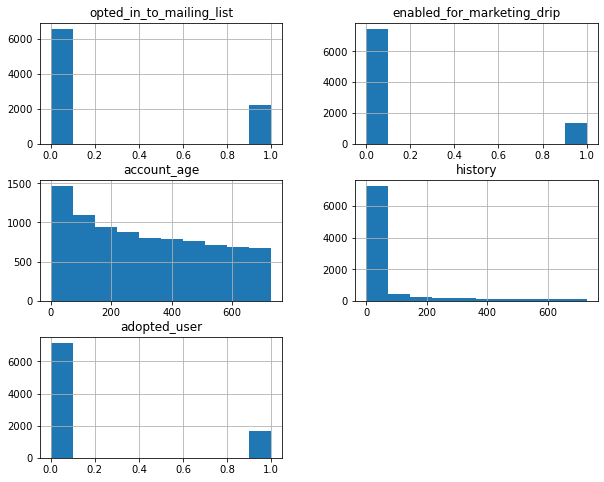

In [61]:
merged.hist(figsize=(10,8))

In [62]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
merged = pd.get_dummies(merged)

X = merged.drop(columns='adopted_user', axis=1)
y = merged['adopted_user']

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1995)

(8823, 9) (8823,)


In [63]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=1995)
)

rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.9582153 , 0.96246459, 0.95892351, 0.9588944 , 0.96102055])

In [64]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9599036706733617, 0.0015896960882852394)

In [65]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [66]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [67]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=1995))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': [10, 12, 16,
                                                                  20, 26, 33,
                                                                  42, 54, 69,
                                                                  88, 112, 143,
                                                                  183, 233, 297,
                                                                  379, 483, 615,
                                                                  784, 1000],
                         'standardscaler': [StandardScaler(), None]})

In [68]:
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 183,
 'standardscaler': StandardScaler()}

In [69]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores, np.mean(rf_best_scores), np.std(rf_best_scores)

(array([0.95892351, 0.96388102, 0.95679887, 0.96031184, 0.96172927]),
 0.9603289010064587,
 0.002408947073198904)

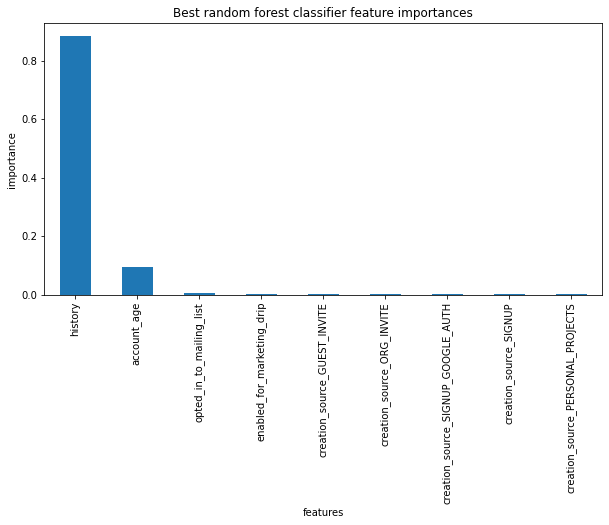

In [70]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

In [71]:
forest=RandomForestClassifier(max_depth= 10, n_estimators=112,random_state=1995)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
y_pred = pd.Series(y_pred)

from sklearn.metrics import classification_report, confusion_matrix
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred,output_dict=True)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" %(result2*100.00))

Confusion Matrix:
[[1428   27]
 [  41  269]]
Classification Report:
{'0': {'precision': 0.9720898570456092, 'recall': 0.9814432989690721, 'f1-score': 0.9767441860465117, 'support': 1455}, '1': {'precision': 0.9087837837837838, 'recall': 0.867741935483871, 'f1-score': 0.8877887788778879, 'support': 310}, 'accuracy': 0.9614730878186969, 'macro avg': {'precision': 0.9404368204146965, 'recall': 0.9245926172264716, 'f1-score': 0.9322664824621998, 'support': 1765}, 'weighted avg': {'precision': 0.9609709433282347, 'recall': 0.9614730878186969, 'f1-score': 0.9611202901698696, 'support': 1765}}
Accuracy: 96.15%


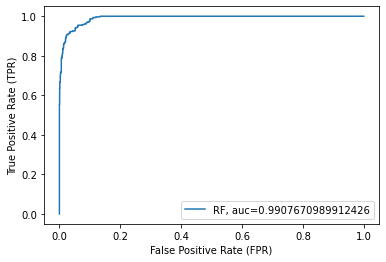

In [72]:
y_pred_proba = forest.predict_proba(X_test)[::,1]
fpr, tpr, _=metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='RF, auc='+str(auc))
plt.xlabel(xlabel='False Positive Rate (FPR)')
plt.ylabel(ylabel='True Positive Rate (TPR)')
plt.legend(loc=4)
plt.show()

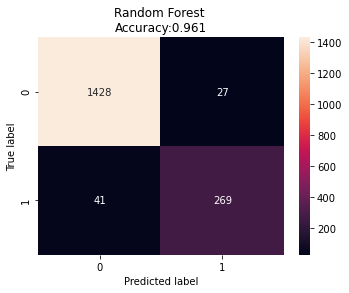

In [73]:
plt.figure(figsize=(5.5,4))
sns.heatmap(result, annot=True, fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

<AxesSubplot:>

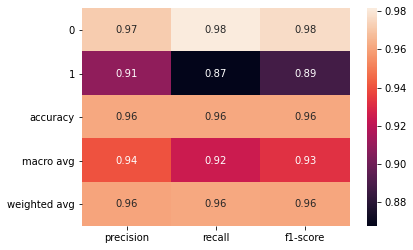

In [74]:
sns.heatmap(pd.DataFrame(result1).iloc[:-1, :].T, annot=True)

# The most important feature is history.